# RentHop House Listing Price Prediction

The final project for DS-GA1001 Introduction to Data Science

## Package Import

In [126]:
# Python
from collections import defaultdict
# Data Analysis
import numpy as np # linear algebra
import scipy as sp
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# I/O
import os
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Exploration and Preprocessing

Read data and look at the variables we have

In [3]:
def data_cleaning(infile):
    # Import Data
    df = pd.read_json("../data/train.json")
    print df.shape
    return df
df = data_cleaning('../data/train.json')
df.head()

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


## Split Training Set and Test Set

We are spliting the available data into training set and test set

In [94]:
def data_split(df):
    df_y = df[['price']]
    df_X = df.drop('price', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_split(df)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(39481, 14) (9871, 14) (39481, 1) (9871, 1)


### --------- From now on, we only use the training set for modeling and validation ---------

## Data Explorations

### Addresses

We use displayed address and see what are the most frequently listed addresses

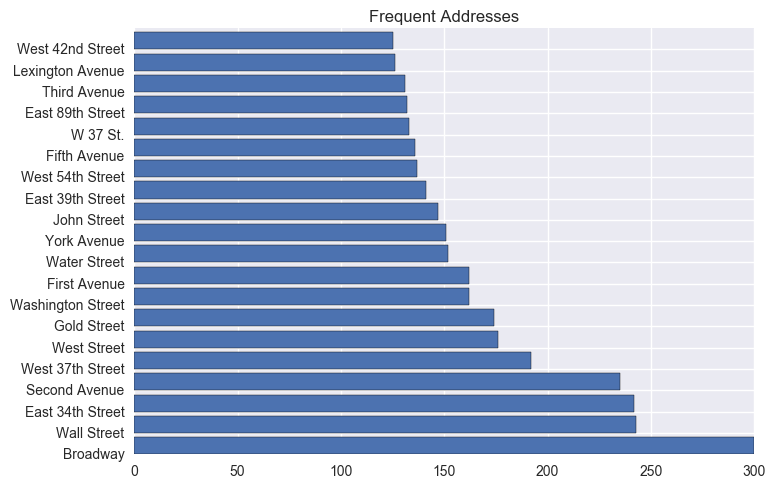

In [6]:
address_counts = X_train['display_address'].value_counts()
plt.figure()
plt.barh(range(len(address_counts))[:20],address_counts.values[:20],tick_label=address_counts.index[:20])
plt.title('Frequent Addresses')
# Most frequently used addresses
plt.show()

### Features

We filter out some features that appear multiple times (> 50) among all training samples. We make them lower cases before hand

<Container object of 79 artists>

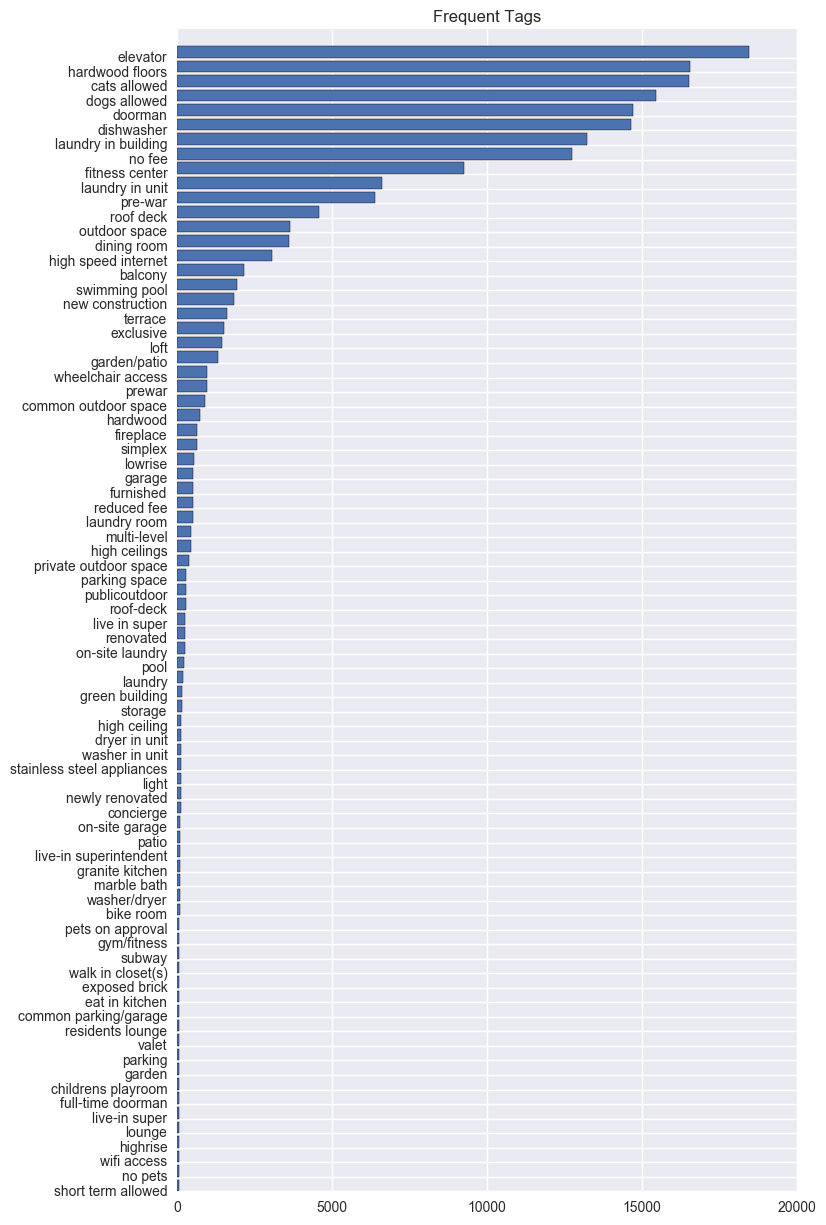

In [7]:
# Extract all features
all_features = defaultdict(int)
for f in X_train['features']:
    for i in f:
        i = i.lower() # Convert to lower cases
        all_features[i] = all_features[i] + 1
all_features_sorted = []
for kk,vv in all_features.items():
    if vv > 50: # Appear more than a certain times
        all_features_sorted.append((kk,vv))
# Take a look at the most frequently listed features
all_features_sorted = sorted(all_features_sorted, key=lambda x: x[1])
all_features_index = map(lambda x: x[0], all_features_sorted)
all_features_values = map(lambda x: x[1], all_features_sorted)
plt.figure(figsize=(8, 15))
plt.title('Frequent Tags')
plt.barh(range(len(all_features_sorted)), all_features_values,tick_label=all_features_index)

### Managers

The manager data is also interesting, listings are monitored by different managers

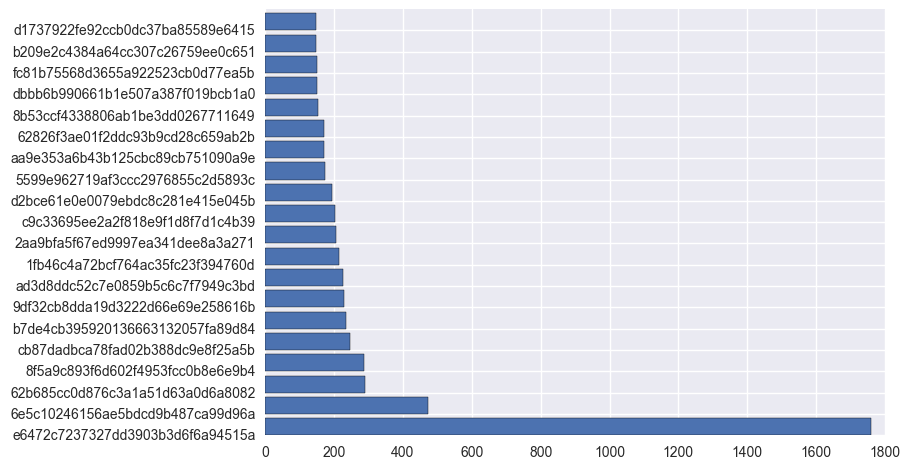

In [8]:
manager_counts = X_train['manager_id'].value_counts()
plt.figure()
plt.barh(range(len(manager_counts))[:20],manager_counts.values[:20],tick_label=manager_counts.index[:20])
# Most frequently used addresses
plt.show()

## Feature Extraction

### Extract Key Words in Addresses

In [104]:
def process_address(train_data, val_data, test_data):
    vec = CountVectorizer(min_df=1, binary=True)
    vec.fit(train_data['display_address'])
    new_columns =  vec.get_feature_names()
    new_columns = map(lambda x: 'address_'+str(x), new_columns)
    new_train = pd.DataFrame(index=train_data.index, data=vec.transform(train_data['display_address']).todense(), columns=new_columns)
    new_val = pd.DataFrame(index=val_data.index, data=vec.transform(val_data['display_address']).todense(), columns=new_columns)
    new_test = pd.DataFrame(index=test_data.index, data=vec.transform(test_data['display_address']).todense(), columns=new_columns)
    merge_train = pd.merge(train_data, new_train, left_index=True, right_index=True)
    merge_val = pd.merge(val_data, new_val, left_index=True, right_index=True)
    merge_test = pd.merge(test_data, new_test, left_index=True, right_index=True)
    return merge_train, merge_val, merge_test

### Extract Key Words in Tags

In [99]:
def process_tags(train_data, val_data, test_data):
    vec = CountVectorizer(min_df=1, binary=True)
    train = train_data.copy()
    val = val_data.copy()
    test = test_data.copy()
    train['features'] = map(lambda x: ' '.join(x), train_data['features'])
    val['features'] = map(lambda x: ' '.join(x), val_data['features'])
    test['features'] = map(lambda x: ' '.join(x), test_data['features'])
    vec.fit(train['features'])
    new_columns =  vec.get_feature_names()
    new_columns = map(lambda x: 'feature_'+x.encode('utf-8').strip(), new_columns)
    new_train = pd.DataFrame(index=train.index, data=vec.transform(train['features']).todense(), columns=new_columns)
    new_val = pd.DataFrame(index=val.index, data=vec.transform( val['features']).todense(), columns=new_columns)
    new_test = pd.DataFrame(index=test.index, data=vec.transform( test['features']).todense(), columns=new_columns)
    merge_train = train_data.merge(new_train, left_index=True, right_index=True)
    merge_val = val_data.merge(new_val, left_index=True, right_index=True)
    merge_test = test_data.merge(new_test, left_index=True, right_index=True)
    return merge_train, merge_val, merge_test

### Add features to both training data and test data

In [107]:
def feature_extraction(oridata):
    data = oridata.copy()
    # Extract the number of "photos" and "features" for each listing
    data.ix[:,'num_photos']=data.ix[:,'photos'].apply(len)
    data.ix[:,'num_features']=data.ix[:,'features'].apply(len)
    data = data.drop('interest_level',1)
    data = data.drop('manager_id',1)
    return data

### Take out numeric data, transform and rescale

In [34]:
def select_numeric_rescale(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Ignore dummy variables
    scaled = ['bathrooms','bedrooms','latitude','listing_id','longitude','num_photos','num_features']
    X_numeric = data.select_dtypes(include=numerics)
    # Standardize
    scaler = StandardScaler()
    scaler.fit(X_numeric[scaled].values)
    X_numeric.ix[:,scaled] = scaler.transform(X_numeric[scaled])
    X_numeric = pd.DataFrame(data=X_numeric, columns=X_numeric.columns, index = X_numeric.index)
    return X_numeric

### Principle Component Analysis

#### Components Construction

In [76]:
def pca(X_train, X_val, X_test, c=100):
    pca = PCA(c) # 100 Components
    pca.fit(X_train)
    return pca.transform(X_train), pca.transform(X_val), pca.transform(X_test)

#### Components Visualization

In [116]:
# Check what features contribute to the component
def checkComp(mypca, c=0, pre=10):
    sidx = sorted(range(len(cols)), key=lambda x: mypca.components_[c][x])
    scols = [cols[i] for i in sidx[:pre]]
    print scols

## Feature Selection

To select numeric features, we have several choices:
1. Embeded Method: We can use some linear models penalized with the L1 norm to make unimportant features has coefficient of zero.
2. Filter Method: Preprocess the features by using F-test, Correlation Matrix, etc.
3. Wrapper Method: Run model on subsets and score them

### Lasso feature selection

I've tried the recursive feature elimination method, but takes too much time, so we can instead use Lasso feature selection for the numeric data

In [120]:
# Embeded Method: Lasso 
# Reference: Wikipedia-Feature Selection
def lasso_feature_selection(X,y,num=-1):
    estimator = Lasso()
    estimator.fit(X,y)
    selector = SelectFromModel(estimator, prefit=True, threshold=0.5)
    X_new = selector.transform(X)
    # n_features indicates the number of features we want
    n_features = X_new.shape[1]
    if num >= 0:
        while n_features > num:
            selector.threshold += 0.1
            X_new = selector.transform(X)
            n_features = X_new.shape[1]
    print selector.get_support() # We can see that only the first two features "bedroom", "bathroom" remains
    return X_new

### F-regression feature selection

In [141]:
# Filter Method: f-regression
def freg(X, y, num=-1):
    cols = X.columns
    if num == -1:
        num = 10
    fs,ps = f_regression(X,y.values)
    sidx = sorted(range(len(cols)), key=lambda x: ps[x])[:num]
    return [cols[i] for i in sidx]

### Gradient Boosting

In [75]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
skf = KFold(n_splits=10)
# specify parameters via map
param = {}
num_round = 10

# Cross Validation
for train_idx, test_idx in skf.split(X_new, y):
    # print("%s %s" % (train_idx, test_idx))
    kf_X_train, kf_X_test = X_new[train_idx], X_new[test_idx]
    kf_y_train, kf_y_test = y[train_idx], y[test_idx]
    dtrain = xgb.DMatrix(kf_X_train, label=kf_y_train)
    dtest = xgb.DMatrix(kf_X_test)
    model = xgb.train(param, dtrain, num_round)
    preds = model.predict(dtest)
    print mean_squared_error(kf_y_test, preds)
# make prediction


19626963.1128
7353017.10717
1955374.30803
40530512.2939
11371550.8413
71125465.7337
339704247.635
27559121.1519
5836987395.35
56821664.6456


The performance of this model is very ugly because we haven't do any model selection and feature engineering

## Model Selection

### Feature Extraction

In [121]:
# Split Validation Set
X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
print X_train_set.shape, X_val_set.shape, X_test.shape

# Add Feature Lengths
X_train_new = feature_extraction(X_train_set)
X_val_new = feature_extraction(X_val_set)
X_test_new = feature_extraction(X_test)

# Address/Tag Feature Extraction
# Notice that we only create word vector from training data
X_train_merge, X_val_merge, X_test_merge = process_address(X_train_new, X_val_new, X_test_new)
X_train_merge, X_val_merge, X_test_merge = process_tags(X_train_merge, X_val_merge, X_test_merge)

# Numerical Feature Standardization
X_train_numeric_merge = select_numeric_rescale(X_train_merge)
X_val_numeric_merge = select_numeric_rescale(X_val_merge)
X_test_numeric_merge = select_numeric_rescale(X_test_merge)

print X_train_numeric_merge.shape, X_val_numeric_merge.shape, X_test_numeric_merge.shape

(27636, 14) (11845, 14) (9871, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27636 entries, 110381 to 95800
Columns: 3040 entries, bathrooms to feature_your
dtypes: float64(7), int64(3033)
memory usage: 641.2 MB
None
(27636, 3040) (11845, 3040) (9871, 3040)


### Feature Selection

In [151]:
# Dimension Reduction and Feature Selection
def featureSelFre(X_train, y_train, X_val, X_test, num=10):
    sig_cols = freg(X_train, y_train,num)
    X_train_new = X_train[sig_cols]
    X_val_new = X_val[sig_cols]
    X_test_new = X_test[sig_cols]
    print sig_cols
    return X_train_new, X_val_new, X_test_new

In [157]:
X_train_final, X_val_final, X_test_final = featureSelFre(X_train_numeric_merge, y_train_set, X_val_numeric_merge, X_test_numeric_merge, 100)
print X_train_final.shape
X_train_final.head()

['address_hudson', 'address_116th', u'bathrooms', u'bedrooms', 'feature_exclusive', 'feature_doorman', 'address_horn', 'address_57th', 'feature_elevator', 'num_features', 'feature_unit', 'feature_dining', 'feature_room', 'feature_dogs', 'feature_cats', 'feature_allowed', 'address_duane', 'address_class', 'address_townhome', 'feature_terrace', u'listing_id', 'address_7712', 'address_utrecht', 'feature_center', 'feature_fitness', 'feature_fireplace', 'feature_balcony', 'address_van', 'address_230', 'feature_pool', 'feature_swimming', 'address_street', 'feature_dishwasher', 'feature_space', 'address_end', 'feature_outdoor', 'feature_simplex', 'address_59th', 'feature_lowrise', 'address_west', 'feature_garden', 'address_high', 'feature_patio', 'feature_level', 'feature_multi', 'feature_deck', 'feature_roof', 'feature_war', 'feature_pre', 'address_86th', 'address_523b', 'address_oak', 'address_triple', 'feature_vacation', 'feature_prewar', 'feature_laundry', 'feature_in', 'address_fifth', '

,address_hudson,address_116th,bathrooms,bedrooms,feature_exclusive,feature_doorman,address_horn,address_57th,feature_elevator,num_features,...,address_cooper,feature_light,address_broadway,feature_green,address_murray,address_84th,feature_subway,address_ocean,address_seventh,feature_live
110381,0,0,-0.424215,-0.485297,0,1,0,0,1,0.136389,...,0,0,0,0,0,0,0,0,0,0
86993,0,0,-0.424215,0.413126,0,0,0,0,0,-0.625433,...,0,0,0,0,0,0,0,0,0,0
88220,0,0,-0.424215,-1.383719,0,0,0,0,0,-0.625433,...,0,0,0,0,0,0,0,0,0,0
76804,0,0,1.574355,0.413126,0,1,0,0,1,0.390330,...,0,0,0,0,0,0,0,0,0,0
51117,0,0,1.574355,2.209972,0,0,0,0,0,-0.371493,...,0,0,0,0,0,0,0,0,0,0


### Validation

In [158]:
allK = [10**x for x in range(-2,10)] # Alpha takes 10^-5 to 10^5

cv_ls = []
cv_rr = []
for k in allK:
        ls = Lasso(alpha=k)
        ls.fit(X_train_final, y_train_set)
        rr = Ridge(alpha=k)
        rr.fit(X_train_final, y_train_set)
        y_val_pred_ls = ls.predict(X_val_final)
        y_val_pred_rr = rr.predict(X_val_final)
        cv_ls.append(mean_squared_error(y_val_set, y_val_pred_ls))
        cv_rr.append(mean_squared_error(y_val_set, y_val_pred_rr))

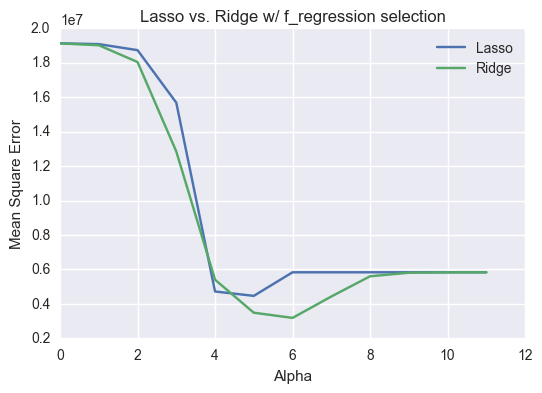

In [161]:
# Plot
plt.figure()
plt.plot(range(len(allK)), cv_ls, label='Lasso')
plt.plot(range(len(allK)), cv_rr, label='Ridge')
plt.legend()
plt.title('Lasso vs. Ridge w/ f_regression selection')
plt.xlabel('Alpha')
plt.ylabel('Mean Square Error')
plt.show()

## Evaluation Of Lasso/Ridge

In [ ]:
print 'Test MSE: {}'.format(mean_squared_error(re, y_test))
print 'R2: {}'.format(r2_score(re, y_test))
fo = open('ridge-select-4-features-scaled.txt','w+')
fo.write('Test MSE: {}\n'.format(mean_squared_error(re, y_test)))
fo.write('R2: {}\n'.format(r2_score(re, y_test)))
for i in range(10):
    fo.write('C: {} Score: {}\n'.format(np.log10(alpha_list[i]), result[i]))
fo.close()

## Deployment